**Importing necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


**Reading the excle file**

In [2]:
df=pd.read_excel('/content/drive/My Drive/preprocessed_data.xlsx')
df.head()

,DateTime,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2,Hour
0,2021-11-01 00:00:00,0,1,44,1,11,2021,0,315.31,3388.77,49.26,6.0,9.3,600.71,356.0,3159.60,54.32,0.0
1,2021-11-01 00:30:00,0,1,44,1,11,2021,1,321.80,3196.66,49.26,6.0,11.1,605.42,317.0,2973.01,54.23,0.0
2,2021-11-01 01:00:00,0,1,44,1,11,2021,2,328.57,3060.71,49.10,5.0,11.1,589.97,311.0,2834.00,54.23,1.0
3,2021-11-01 01:30:00,0,1,44,1,11,2021,3,335.60,2945.56,48.04,6.0,9.3,585.94,313.0,2725.99,53.47,1.0
4,2021-11-01 02:00:00,0,1,44,1,11,2021,4,342.90,2849.34,33.75,6.0,11.1,571.52,346.0,2655.64,39.87,2.0


In [3]:
df=df.set_index('DateTime')

<Axes: title={'center': 'Energy use'}, xlabel='DateTime'>

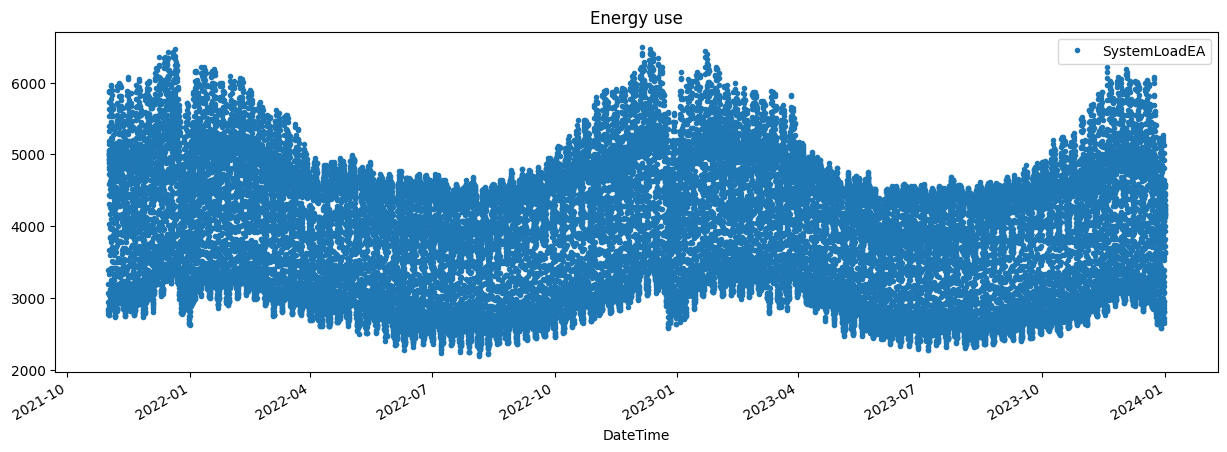

In [4]:
color_pal=sns.color_palette()
df.plot(y='SystemLoadEA', style='.',figsize=(15,5),color=color_pal[0],title="Energy use")

In [5]:
df.index

DatetimeIndex(['2021-11-01 00:00:00', '2021-11-01 00:30:00',
               '2021-11-01 01:00:00', '2021-11-01 01:30:00',
               '2021-11-01 02:00:00', '2021-11-01 02:30:00',
               '2021-11-01 03:00:00', '2021-11-01 03:30:00',
               '2021-11-01 04:00:00', '2021-11-01 04:30:00',
               ...
               '2023-12-31 19:00:00', '2023-12-31 19:30:00',
               '2023-12-31 20:00:00', '2023-12-31 20:30:00',
               '2023-12-31 21:00:00', '2023-12-31 21:30:00',
               '2023-12-31 22:00:00', '2023-12-31 22:30:00',
               '2023-12-31 23:00:00', '2023-12-31 23:30:00'],
              dtype='datetime64[ns]', name='DateTime', length=38014, freq=None)

**Graph of weekly energy use**

<Axes: title={'center': 'Weekly energy'}, xlabel='DateTime'>

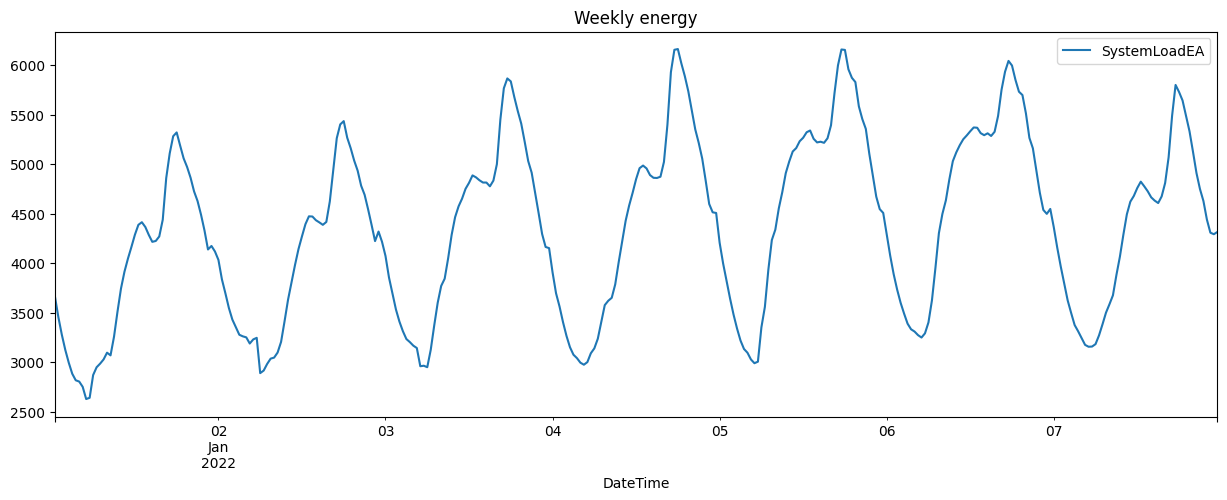

In [6]:
df.loc[(df.index>'01-01-2022')&(df.index<'01-08-2022')].plot(y='SystemLoadEA', figsize=(15,5),color=color_pal[0],title="Weekly energy")

<Axes: title={'center': 'Weekly energy'}, xlabel='DateTime'>

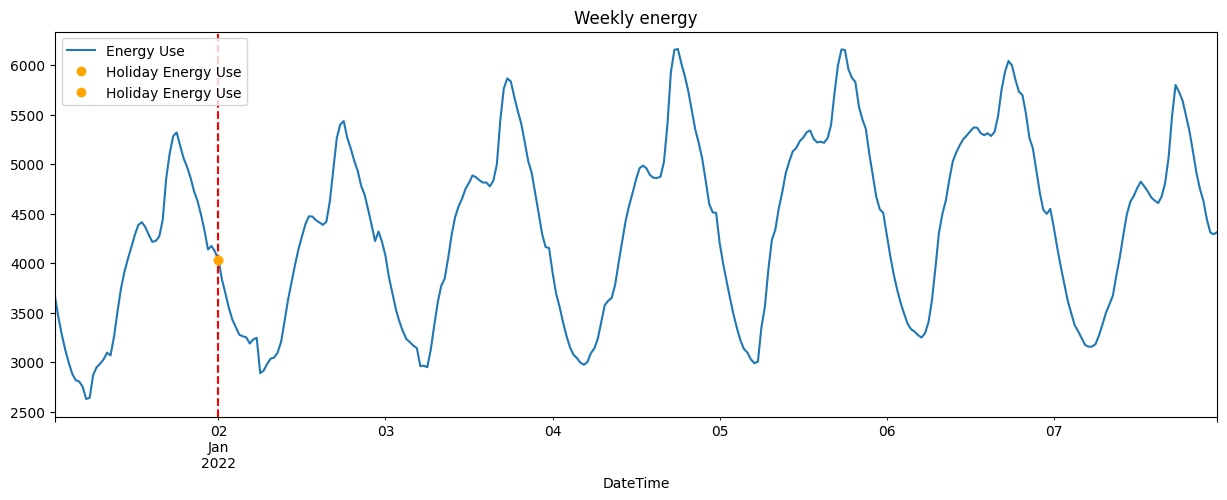

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a 'HolidayFlag' column in your DataFrame
# and a list of holiday dates called 'holiday_dates'
holiday_dates = df.loc[df['HolidayFlag'] == 1].index  # Get dates where HolidayFlag is 1

# Get unique holiday dates
unique_holiday_dates = holiday_dates.normalize().unique()

# Plot the SystemLoadEA data
ax = df.loc[(df.index > '01-01-2022') & (df.index < '01-08-2022')].plot(
    y='SystemLoadEA', figsize=(15, 5), color=color_pal[0], title="Weekly energy", label='Energy Use'
)

# Add vertical lines for unique holidays within the specified date range
# Convert string dates to Timestamp objects for comparison
start_date = pd.Timestamp('2022-01-01')
end_date = pd.Timestamp('2022-01-08')
for holiday in unique_holiday_dates:  # Iterate through unique dates
    # Compare Timestamp objects instead of strings
    if start_date < holiday < end_date:
        ax.axvline(x=holiday, color='red', linestyle='--', label='Holiday')

# Filter data for holidays within the date range, keeping only the first hourly entry for each day
holiday_data = df.loc[(df.index.normalize().isin(unique_holiday_dates)) & (df.index > start_date) & (df.index < end_date)]
holiday_data = holiday_data.groupby(holiday_data.index.date).first()  # Get first entry per day

# Convert the index to DatetimeIndex before plotting
holiday_data.index = pd.to_datetime(holiday_data.index)

# Plot holiday data with a different color
holiday_data.plot(y='SystemLoadEA', ax=ax, style='o', color='orange', label='Holiday Energy Use')

holiday_data.plot(y='SystemLoadEA', ax=ax, style='o', color='orange', label='Holiday Energy Use')



**Feature creation**

In [8]:
def create_features(df):
  df['hour']=df.index.hour
  df['dayofweek']=df.index.dayofweek
  df['quarter']=df.index.quarter
  df['dayofyear']=df.index.dayofyear
  df['month']=df.index.month
  df['year']=df.index.year
  return df
df=create_features(df)

**Graph of hourly energy use**

<ipython-input-9-7fb74ca53f6a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x='hour',y='SystemLoadEA',palette=color_pal)
<ipython-input-9-7fb74ca53f6a>:3: UserWarning: 
The palette list has fewer values (10) than needed (24) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df,x='hour',y='SystemLoadEA',palette=color_pal)


Text(0.5, 1.0, 'Energy use by hour')

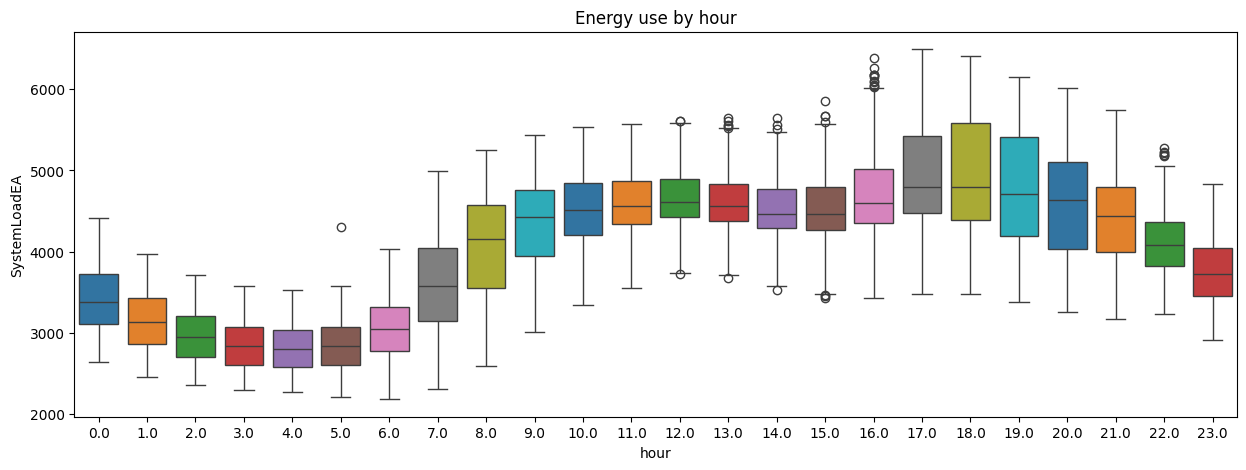

In [ ]:
df = df.reset_index()
fig,ax=plt.subplots(figsize=(15,5))
sns.boxplot(data=df,x='hour',y='SystemLoadEA',palette=color_pal)
ax.set_title('Energy use by hour')

**Graph of monthly energy usage**

<ipython-input-10-24d1a91f9758>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x='month',y='SystemLoadEA',palette='Blues')


Text(0.5, 1.0, 'Energy use by month')

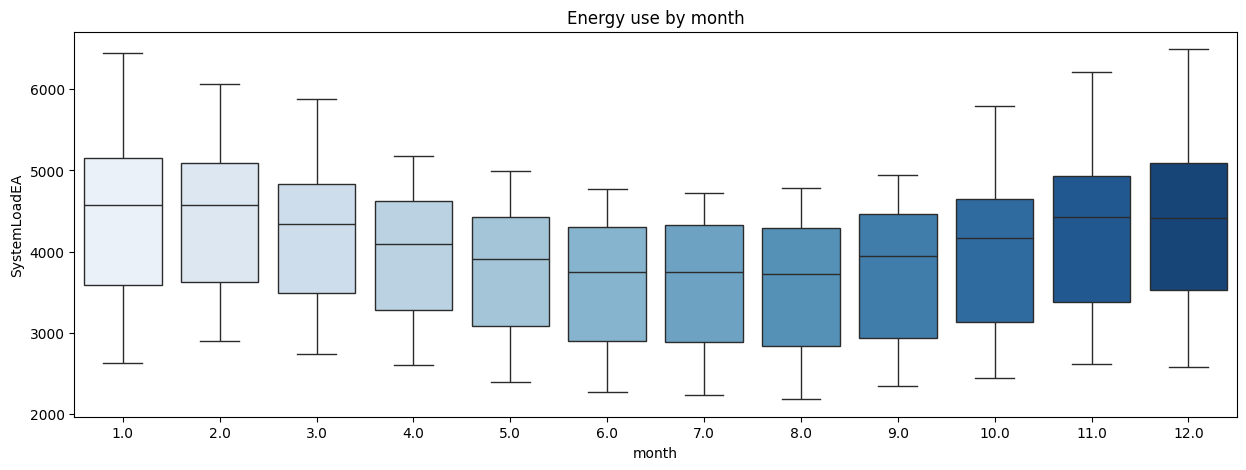

In [ ]:
fig,ax=plt.subplots(figsize=(15,5))
sns.boxplot(data=df,x='month',y='SystemLoadEA',palette='Blues')
ax.set_title('Energy use by month')

**Train Test Split**

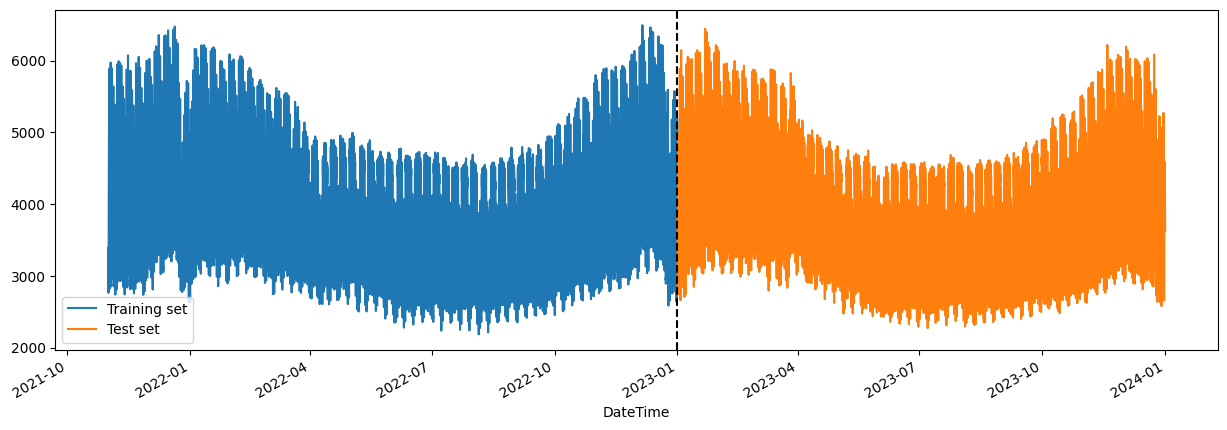

In [ ]:
train = df.loc[df['DateTime'] < '01-01-2023']
test = df.loc[df['DateTime'] >= '01-01-2023']
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training set', x='DateTime', y='SystemLoadEA')
test.plot(ax=ax, label='Test set', x='DateTime', y='SystemLoadEA')
ax.axvline('01-01-2023', color='black', ls='--')
ax.legend(['Training set', 'Test set'])
plt.show()

**Creating Model**

In [ ]:
train = train.set_index('DateTime') # Setting 'DateTime' as index
test = test.set_index('DateTime')
train=create_features(train)
test=create_features(test)

In [ ]:
df.columns

Index(['DateTime', 'HolidayFlag', 'DayOfWeek', 'WeekOfYear', 'Day', 'Month',
       'Year', 'PeriodOfDay', 'ForecastWindProduction', 'SystemLoadEA',
       'SMPEA', 'ORKTemperature', 'ORKWindspeed', 'CO2Intensity',
       'ActualWindProduction', 'SystemLoadEP2', 'SMPEP2', 'Hour', 'hour',
       'dayofweek', 'quarter', 'dayofyear', 'month', 'year'],
      dtype='object')

In [ ]:
Features=['DateTime', 'HolidayFlag', 'DayOfWeek', 'WeekOfYear', 'Day', 'Month',
       'Year', 'PeriodOfDay', 'ForecastWindProduction', 'SystemLoadEA',
       'SMPEA', 'ORKTemperature', 'ORKWindspeed', 'CO2Intensity',
       'ActualWindProduction', 'SystemLoadEP2', 'SMPEP2', 'Hour', 'hour',
       'dayofweek', 'quarter', 'dayofyear', 'month', 'year']
Target='SystemLoadEA'

In [ ]:
X_train = train[[col for col in Features if col != 'DateTime' and col in train.columns]]
X_test = test[[col for col in Features if col != 'DateTime' and col in test.columns]]
y_train = train[Target]
y_test = test[Target]

In [ ]:
!pip install scikit-learn==1.2.0
!pip install xgboost
# Check for and handle invalid values in y_train and y_test
y_train = y_train.replace([np.inf, -np.inf], np.nan) # Replace inf with NaN
y_train = y_train.fillna(y_train.mean()) # Replace NaN with mean

y_test = y_test.replace([np.inf, -np.inf], np.nan)
y_test = y_test.fillna(y_test.mean())


y_train = y_train.astype('float64')
y_test = y_test.astype('float64')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 59.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.31.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.2.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.0 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.0 which is incompatible.


In [ ]:
from sklearn.preprocessing import StandardScaler

# Creating a scaler object
scaler = StandardScaler()

# Fit the scaler to the training data and transform
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
# Pass the scaled data to eval_set as well
reg.fit(X_train_scaled, y_train,
        eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
        verbose=2)

# Get feature names from original X_train DataFrame
feature_names = X_train.columns


[0]	validation_0-rmse:611.53476	validation_1-rmse:593.84737
[2]	validation_0-rmse:300.65696	validation_1-rmse:291.93318
[4]	validation_0-rmse:147.98521	validation_1-rmse:144.62752
[6]	validation_0-rmse:73.16031	validation_1-rmse:73.90821
[8]	validation_0-rmse:36.76310	validation_1-rmse:42.11239
[10]	validation_0-rmse:19.45127	validation_1-rmse:29.90500
[12]	validation_0-rmse:11.67514	validation_1-rmse:26.07517
[14]	validation_0-rmse:8.57915	validation_1-rmse:25.04726
[16]	validation_0-rmse:7.43932	validation_1-rmse:24.71252
[18]	validation_0-rmse:6.83507	validation_1-rmse:24.70560
[20]	validation_0-rmse:6.51275	validation_1-rmse:24.63648
[22]	validation_0-rmse:6.33047	validation_1-rmse:24.60703
[24]	validation_0-rmse:5.96829	validation_1-rmse:24.85994
[26]	validation_0-rmse:5.77491	validation_1-rmse:24.82212
[28]	validation_0-rmse:5.50140	validation_1-rmse:24.82810
[30]	validation_0-rmse:5.39793	validation_1-rmse:24.78076
[32]	validation_0-rmse:5.28727	validation_1-rmse:24.72100
[34]	v

In [ ]:
test['prediction']=reg.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Get predictions for the test set
predictions = reg.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 605.3860440916484
Root Mean Squared Error (RMSE): 24.604593963153473
Mean Absolute Error (MAE): 4.382358977797532
R-squared (R2): 0.999152102971181


**Predicting future energy consumption**

In [ ]:
import pandas as pd

# Create a DataFrame for the prediction date
prediction_date = pd.to_datetime('2025-01-16')
prediction_df = pd.DataFrame(index=[prediction_date])
# Create time-related features for the prediction date
prediction_df['hour'] = prediction_df.index.hour
prediction_df['dayofweek'] = prediction_df.index.dayofweek
prediction_df['quarter'] = prediction_df.index.quarter
prediction_df['dayofyear'] = prediction_df.index.dayofyear
prediction_df['month'] = prediction_df.index.month
prediction_df['year'] = prediction_df.index.year

# Include all features used during training
for feature in X_train.columns:
    if feature not in prediction_df.columns:
        prediction_df[feature] = 0  # Initialize missing features to 0


# Select only time-related features and SystemLoadEA
X_prediction = prediction_df[[col for col in Features if col != 'DateTime' and col in prediction_df.columns]]
X_prediction_scaled = scaler.transform(X_prediction)
# Make the prediction
predicted_energy_use = reg.predict(X_prediction_scaled)[0]
print(f"Predicted energy use on 2025-01-12: {predicted_energy_use}")

Predicted energy use on 2025-01-12: 2296.3271484375
